## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [3]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/mmus/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/mmus/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/mmus/'
gtf_name = 'mm10.refGene.gtf'
mutation = 'Fmr1'
samp_num = '3'
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

# Loading up the csv file.

In [5]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

## Determine KS statistic for all transcripts

In [6]:
len(transcripts)

44446

In [7]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    p_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, transcripts):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
            smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)
            ks, p = stats.ks_2samp(cumul_m, cumul_c)
            ks_list.append(ks)
            p_list.append(p)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            

    # Calculate the -10 log of the P values in order to visualize the smallest values. 
    log_p = []
    for p in p_list:
        if p != 0:
            log_p.append(math.log(p, 0.1))
        else:
            log_p.append(200)
            
    # reorganizing the lists into a dataframe. 
    df = pd.DataFrame(list(zip(p_list, log_p, ks_list, gene_list, tr_id)))
    df.columns = ["p_value","-10log(p)","ks_stat", "gene_ID","transcript_ID"]

In [9]:
# Save as a csv
if pre_load == False:
    df.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [10]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

In [11]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets.csv')

Text(0.5, 1.0, '-10log transformed p-values of all KS tests (mouse)')

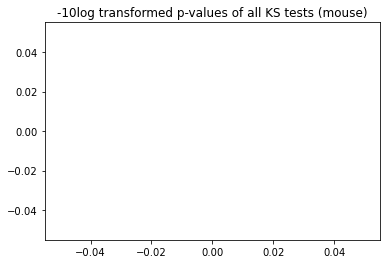

In [12]:
# plot the -10log p_values for the Fmr1 targets
df2 = pd.merge(df, Fmr1_targets, how = "inner", left_on="gene_ID", right_on="MOUSE")
plt.scatter(list(range(len(df2['-10log(p)']))), df2['-10log(p)'])
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

In [13]:
# print out all of the genes with P-values below a certain threshold. 
diff_dist = zip(df["transcript_ID"][df['-10log(p)'] > 100],df["gene_ID"][df['-10log(p)'] > 100])

In [14]:
list(diff_dist)

[('NR_149827', 'Hnrnpu'),
 ('NR_153503', 'Hnrnpk'),
 ('NR_153504', 'Hnrnpk'),
 ('NR_153501', 'Hnrnpk'),
 ('NR_153502', 'Hnrnpk'),
 ('NR_152441', 'Rangap1'),
 ('NR_002883_2', 'Gm5643'),
 ('NR_038091', 'Morf4l1-ps1'),
 ('NR_037854', 'Atp6v0c-ps2'),
 ('NR_046233', 'Rn45s'),
 ('NR_045524', 'Osbpl1a'),
 ('NR_149318', 'Snap25'),
 ('NM_001077507', 'Gnas'),
 ('NM_010309', 'Gnas'),
 ('NR_133683', 'Stx1a'),
 ('NR_152855', 'Stx1a'),
 ('NM_008808', 'Pdgfa'),
 ('NM_001363271', 'Pdgfa'),
 ('NR_104468', 'Hnrnpa2b1'),
 ('NR_151824', 'Nptn'),
 ('NR_002883', 'Gm5643')]

Text(0.5, 1.0, 'KS statistic of all mouse transcripts')

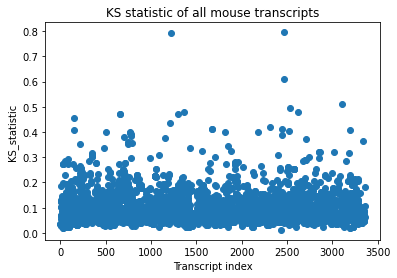

In [15]:
plt.scatter(list(range(len(df["ks_stat"]))), df["ks_stat"])
plt.ylabel("KS_statistic")
plt.xlabel("Transcript index")
plt.title("KS statistic of all mouse transcripts")

Text(0.5, 1.0, '-10log transformed p-values of all KS tests (mouse)')

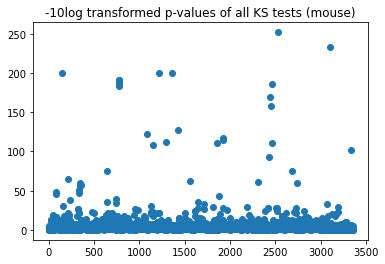

In [173]:
plt.scatter(list(range(len(log_p))), log_p)
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

## Choose the gene of interest and smooth out the array.

In [208]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_trans_mmus('Gm5643', 
                                           transcripts, data_mutant, data_control)

In [209]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [210]:
sum(my_vec_control)/len(my_vec_control)

0.8517022504327756

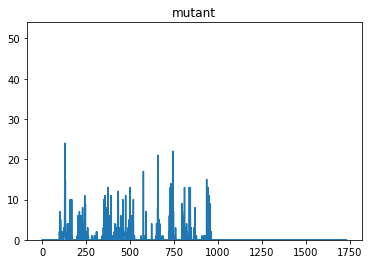

Text(0.5, 1.0, 'control')

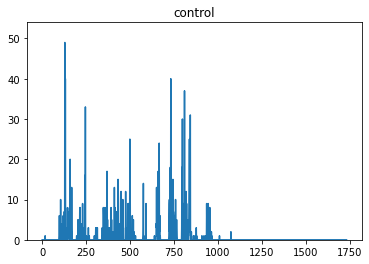

In [211]:
plt.plot(my_vec_mutant)
plt.ylim([0,max(my_vec_control)+5])
plt.title("mutant")
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,max(my_vec_control)+5])
plt.title("control")

When looking at the absolute largest values of P, we find this shape where the reads completely smooth out over time very consistently. 

In [212]:
sum(my_vec_mutant)

916

In [236]:
def get_smoothed_vector(positions, vector, frac = 0.05):
    loess = kat.Loess(positions, vector)
    smoothed_vec = []
    for x in positions:
        y = loess.estimate(x, window=int(len(positions)*frac), use_matrix=False, degree=1)
        smoothed_vec.append(y)
    smoothed_vec = np.array(smoothed_vec)
    cumsum = np.cumsum(smoothed_vec)/sum(smoothed_vec)
    return smoothed_vec, cumsum

In [237]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_position, my_vec_control+0.00000000001)
smoothed_vec_m2, cumul_m2 = get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c2, cumul_c2 = get_smoothed_vector(my_position, my_vec_control+0.00000000001)


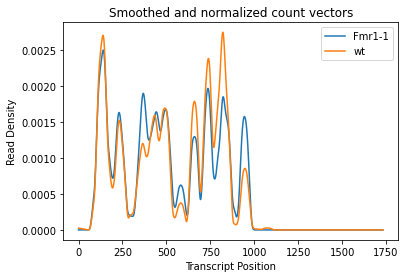

In [238]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

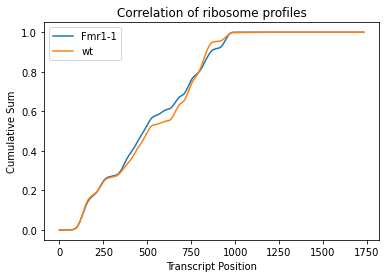

In [244]:
plt.plot(my_position, cumul_m2, label = "Fmr1-1")
plt.plot(my_position, cumul_c2, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Correlation of ribosome profiles")
plt.legend()

In [246]:
stats.ks_2samp(cumul_m, cumul_c)

KstestResult(statistic=0.3641084824004616, pvalue=1.6633534714409111e-102)

In [247]:
stats.pearsonr(cumul_m, cumul_c)

(0.9983354562281074, 0.0)

Wait a second, if I am using the cumulative sum for these KS-tests than wouldn't the P-values scale up with the length of the transcript since the function is going to take the number of inputs as the number of independent samples? like, if it sees a bunch of zeroes it is going to think that we actually ran a test and got a bunch of zeroes wont it? and this would apply to the normal data too. 

In [130]:
df[df["gene_ID"] == "Zcchc18"]

,p_value,-10log(p),ks_stat,gene_ID,transcript_ID
3324,0.000961,1.508569,0.080372,Zcchc18,NM_001358437
3325,0.000961,1.508569,0.080372,Zcchc18,NM_001358441
3326,0.000961,1.508569,0.080372,Zcchc18,NM_001358439
3327,0.000961,1.508569,0.080372,Zcchc18,NM_025893
3328,0.000961,1.899596,0.080372,Zcchc18,NM_001035509
3329,0.000961,0.819879,0.080372,Zcchc18,NM_001035510
3330,0.000961,50.889508,0.080372,Zcchc18,NM_001358440


In [220]:
import inspect